In [16]:
import numpy as np
import pandas as pd
import tracktor as tr
import cv2
import sys
import time
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import os
import glob

%config InteractiveShellApp.pylab_import_all = False
%matplotlib inline
%pylab inline
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

codeDir = 'C:\\Users\\jlarsch\\Documents\\jlsocialbehavior'
os.chdir(codeDir)
import functions.paperFigureProps as pfp
import functions.gui_circle as gc
import functions.video_functions as vf

pfp.paper()



Populating the interactive namespace from numpy and matplotlib
using plot settings for paper plots
standard figure sizes 
 figSq:  (5, 5) 
 figLs:  (5, 3) 
 figPt:  (3, 5)


## Global parameters
This cell (below) enlists user-defined parameters

In [17]:
# colours is a vector of BGR values which are used to identify individuals in the video
# t_id is termite id and is also used for individual identification
# number of elements in colours should be greater than n_inds (THIS IS NECESSARY FOR VISUALISATION ONLY)
# number of elements in t_id should be greater than n_inds (THIS IS NECESSARY TO GET INDIVIDUAL-SPECIFIC DATA)
n_inds = 12
t_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','K','L','M']
colours = [(0,0,255),(0,255,255),(255,0,255),(255,255,255),(255,255,0),(255,0,0),(0,255,0),(0,0,0),(0,0,100),(0,100,100),(100,0,100),(100,100,100)]

# this is the block_size and offset used for adaptive thresholding (block_size should always be odd)
# these values are critical for tracking performance
block_size = 31
offset = 10

# the scaling parameter can be used to speed up tracking if video resolution is too high (use value 0-1)
scaling = 1

# minimum area and maximum area occupied by the animal in number of pixels
# this parameter is used to get rid of other objects in view that might be hard to threshold out but are differently sized
min_area = 20
max_area = 500

# mot determines whether the tracker is being used in noisy conditions to track a single object or for multi-object
# using this will enable k-means clustering to force n_inds number of animals
mot = True


# name of source video and paths
base="E:\\b\\medaka\\20190611_testPairs 12dpf\\"
video = 'out_id0_30fps_20190612103758'
input_vidpath = base + video + '.avi'
output_vidpath = base + video + '_tracked.avi'
output_filepath = base + video + '_tracked.csv'
codec = 'DIVX' # try other codecs if the default doesn't work ('DIVX', 'avc1', 'XVID') note: this list is non-exhaustive

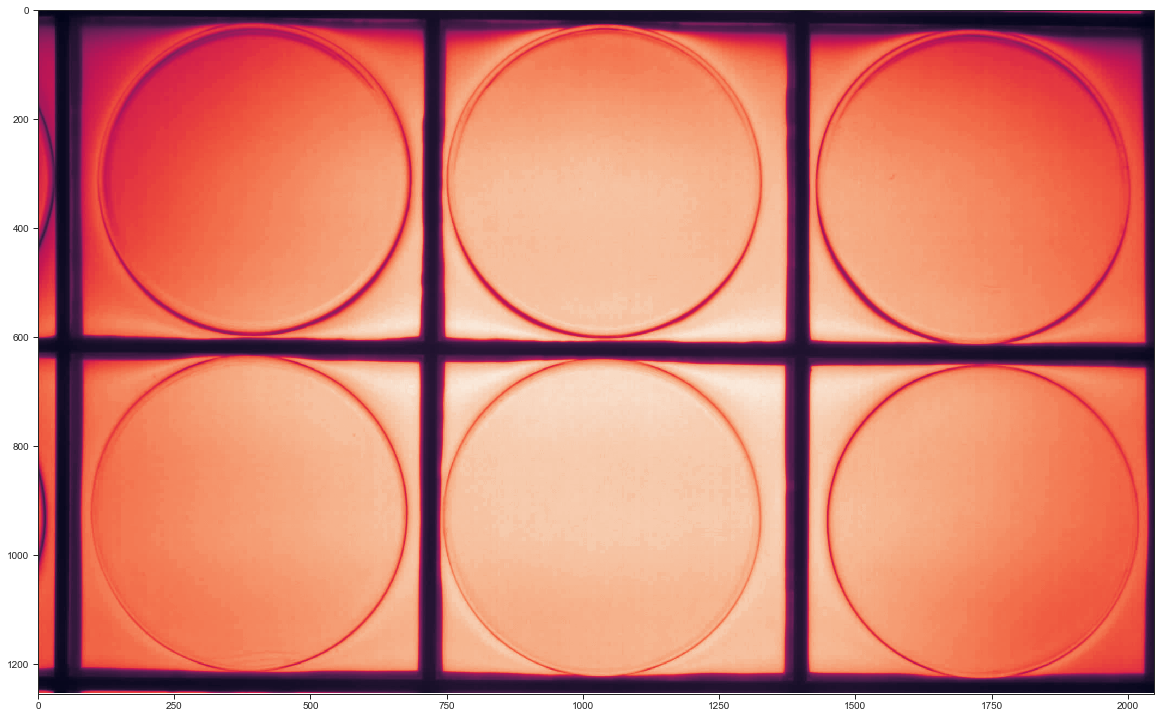

In [5]:
vidMed,vidMed_fn=vf.getMedVideo(input_vidpath)
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(vidMed)

In [6]:
vidMeds = cv2.resize(vidMed, None, fx = scaling, fy = scaling, interpolation = cv2.INTER_LINEAR)

In [7]:

roi_fn=glob.glob(base+"*Med.csv")[0]

rois=pd.read_csv(roi_fn,index_col =0).astype('int')
rois

,circle center x,circle center y,circle radius,square width,square height,square top left x,square top left y,arena size
0,387,925,289,608,608,83,621,70
1,1039,930,296,411,411,833,724,70
2,1737,940,289,-989,-989,2231,1434,70
3,398,315,286,608,608,94,11,70
4,1039,317,290,409,409,834,112,70
5,1717,328,290,-942,-942,2188,799,70


In [8]:
mask = np.zeros(vidMed.shape)
for index,row in rois.iterrows():
    mask = cv2.circle(mask, (row["circle center x"], row["circle center y"]),row["circle radius"] , (255,255,255), -1)

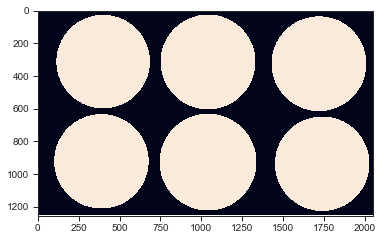

In [9]:
plt.imshow(mask)

The cell below runs the tracking code

In [18]:
## Open video
cap = cv2.VideoCapture(input_vidpath)
if cap.isOpened() == False:
    sys.exit('Video file cannot be read! Please check input_vidpath to ensure it is correctly pointing to the video file')

## Video writer class to output video with contour and centroid of tracked object(s)
# make sure the frame size matches size of array 'final'
fourcc = cv2.VideoWriter_fourcc(*codec)
output_framesize = (int(cap.read()[1].shape[1]*scaling),int(cap.read()[1].shape[0]*scaling))
out = cv2.VideoWriter(filename = output_vidpath, fourcc = fourcc, fps = 60.0, frameSize = output_framesize, isColor = True)

## Individual location(s) measured in the last and current step
meas_last = list(np.zeros((n_inds,2)))
meas_now = list(np.zeros((n_inds,2)))

df = []
last = 0

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    this = cap.get(1)
    
            # Apply mask to aarea of interest

        
    if ret == True:
        # Preprocess the image for background subtraction
        frame[mask ==  0] = 0
        frame = cv2.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv2.INTER_LINEAR)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        bgDiv=(gray/vidMeds)
        bgDiv=bgDiv.astype(np.float32)
        bgDiv = cv2.normalize(bgDiv, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8U)
        
        
        bgDiv = cv2.cvtColor(bgDiv, cv2.COLOR_GRAY2BGR)
        thresh = tr.colour_to_thresh(bgDiv, block_size, offset)
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(bgDiv, thresh, meas_last, meas_now, min_area, max_area)
        if len(meas_now) != n_inds:
            contours, meas_now = tr.apply_k_means(contours, n_inds, meas_now)
        
        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)
        final, meas_now, df = tr.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, mot, this)
        
        # Create output dataframe
        for i in range(n_inds):
            df.append([this, meas_now[i][0], meas_now[i][1], t_id[i]])
        
        # Display the resulting frame
        out.write(final)
        cv2.imshow('frame', final)
        if cv2.waitKey(1) == 27:
            break
            
    if last >= this:
        break
    
    last = this

## Write positions to file
df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y', 'id'])
df.to_csv(output_filepath, sep=',')

## When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## Summary statistics
The cells below provide functions to perform basic summary statistics - in this case, group polarisation and rotation around group centroid and rotation around centre of the arena. Polarisation measures how aligned individuals in a group are whereas rotation is a measure of the group being in a milling state aka. rotating. Checkout Tunstrom et al. 2013 PLoS Computational Biology for a more detailed description.

#### Group showing high polarisation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Group transitioning from high rotation to high polarisation

<img src="imgs/pol.png", width="48%", height="48%", style="float: left">

<img src="imgs/rot2pol.png", width="48%", height="48%", style="float: right">

In [10]:
df = pd.read_csv(output_filepath)
df.head()

,Unnamed: 0,frame,pos_x,pos_y,id
0,0,3.0,1112.786616,412.393939,A
1,1,3.0,854.731813,446.428882,B
2,2,3.0,1241.971429,1082.281633,C
3,3,3.0,881.595420,1121.790076,D
4,4,3.0,432.369565,89.449275,E


In [11]:
df = df.drop(columns=['Unnamed: 0'])
df['dir_x'] = df['pos_x'] - df['pos_x'].shift(n_inds)
df['dir_y'] = df['pos_y'] - df['pos_y'].shift(n_inds)
df['speed'] = np.sqrt(df['dir_x']**2 + df['dir_y']**2)
df['dir_x'] /= df['speed']
df['dir_y'] /= df['speed']

# drop any inf in data
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")

df.head()

,frame,pos_x,pos_y,id,dir_x,dir_y,speed
12,4.0,1112.563802,412.450521,A,-0.969237,0.246128,0.229886
13,4.0,854.460784,446.238562,B,-0.818381,-0.574676,0.331177
14,4.0,1241.445333,1083.322667,C,-0.451035,0.892506,1.166417
15,4.0,872.990012,1112.955056,D,-0.697737,-0.716354,12.333313
16,4.0,432.251488,89.400298,E,-0.923690,-0.383141,0.127832


In [12]:
for idx, ID in enumerate(np.unique(df['id'])):
    df['id'][df['id'] == ID] = idx

C:\Users\jlarsch\AppData\Local\Continuum\miniconda3\envs\tracktor\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


FileNotFoundError: [Errno 2] No such file or directory: 'imgs/ex4_fig1.eps'

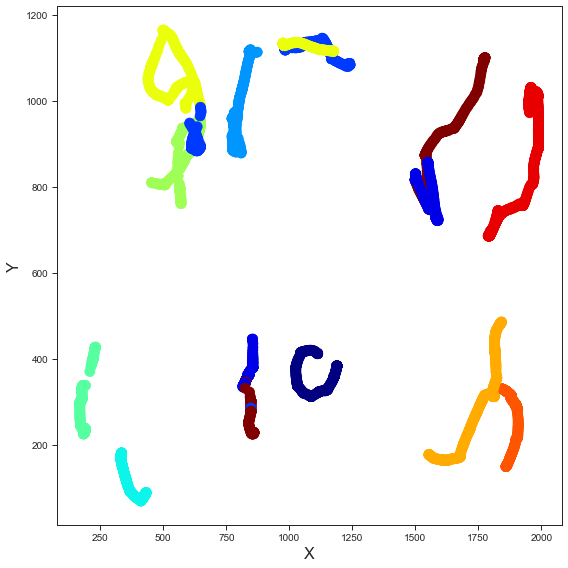

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(df['pos_x'], df['pos_y'], c=df['id'], cmap='jet')#, alpha=0.5)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex4_fig1.eps', format='eps', dpi=300)
plt.show()

In [34]:
df_ord = df.groupby(['frame']).mean()
df_ord = df_ord.reset_index()

df_ord = df_ord.rename(index=str, columns={'pos_x':'centroid_x', 'pos_y':'centroid_y', 'dir_x':'gdir_x', 'dir_y':'gdir_y', 'speed':'gspeed'})

In [35]:
df = pd.merge(df, df_ord, how='left')

In [36]:
tmpx = (df['pos_x'] - df['centroid_x'])
tmpy = (df['pos_y'] - df['centroid_y'])
df['centroid_disp_x'] = tmpx / np.linalg.norm((tmpx, tmpy), axis=0)
df['centroid_disp_y'] = tmpy / np.linalg.norm((tmpx, tmpy), axis=0)

tmpx = (df['pos_x'] - mask.shape[1]//2 + mask_offset_x)
tmpy = (df['pos_x'] - mask.shape[0]//2 + mask_offset_y)
df['arena_centre_disp_x'] = tmpx / np.linalg.norm((tmpx, tmpy), axis=0)
df['arena_centre_disp_y'] = tmpy / np.linalg.norm((tmpx, tmpy), axis=0)

NameError: name 'mask' is not defined

In [37]:
centroid_disp = [df['centroid_disp_x'], df['centroid_disp_y']]
direction = [df['dir_x'], df['dir_y']]

arena_disp = [df['arena_centre_disp_x'], df['arena_centre_disp_y']]

KeyError: 'arena_centre_disp_x'

In [38]:
df['rotation'] = np.cross(np.array(centroid_disp).T, np.array(direction).T)
df['arena_rotation'] = np.cross(np.array(arena_disp).T, np.array(direction).T)

NameError: name 'arena_disp' is not defined

In [39]:
df_ord = df.groupby(['frame']).agg(['sum', 'count'])
df_ord = df_ord.reset_index()

In [76]:
df_ord['polarisation'] = np.sqrt(df_ord['dir_x']['sum']**2 + df_ord['dir_y']['sum']**2) / df_ord['dir_x']['count']
df_ord['rotation'] = df_ord['rotation']['sum'].divide(df_ord['rotation']['count'])
df_ord['arena_rotation'] = df_ord['arena_rotation']['sum'].divide(df_ord['arena_rotation']['count'])

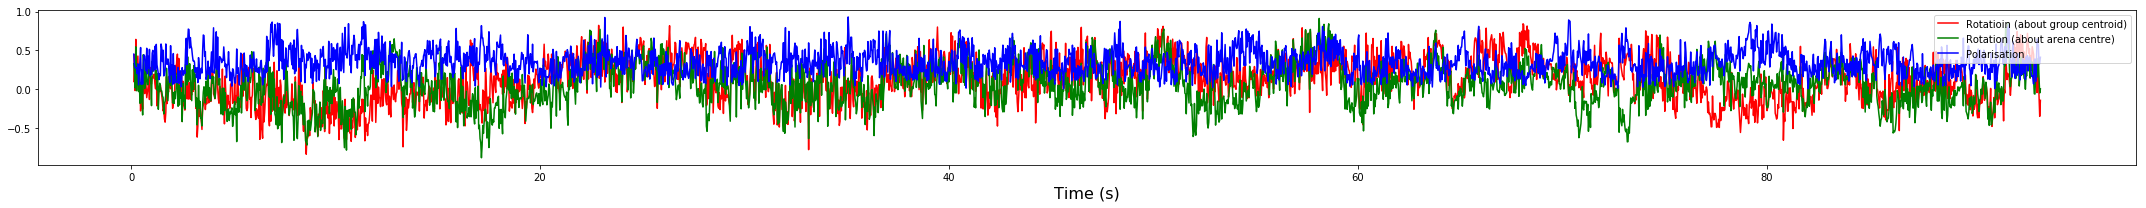

In [81]:
plt.figure(figsize=(30,3))
plt.plot(df_ord['frame']/30, df_ord['rotation']['sum'], color='r', label='Rotatioin (about group centroid)')
plt.plot(df_ord['frame']/30, df_ord['arena_rotation']['sum'], color='g', label='Rotation (about arena centre)') 
plt.plot(df_ord['frame']/30, df_ord['polarisation'], color='b', label='Polarisation')
plt.xlabel('Time (s)', fontsize=16)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('imgs/ex4_fig2.eps', format='eps', dpi=300)
plt.show()

/home/user/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


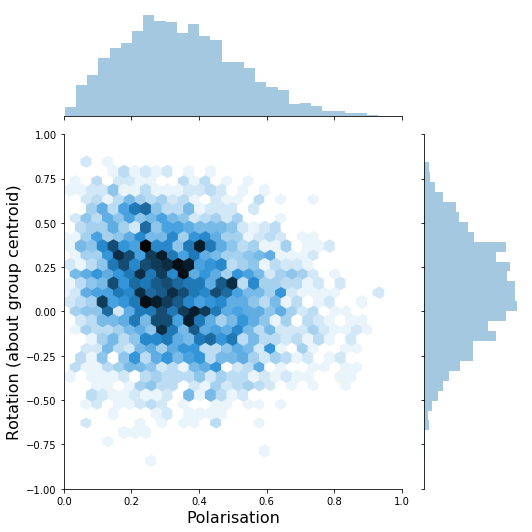

In [82]:
import seaborn as sns

plot = sns.jointplot(df_ord['polarisation'], df_ord['rotation']['sum'], xlim=[0,1], ylim=[-1,1], kind="hex", space=0, size = 7.5, stat_func=None, ratio=3)
plot.set_axis_labels('Polarisation', 'Rotation (about group centroid)', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex4_fig3a.eps', format='eps', dpi=300)
plt.show()

/home/user/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


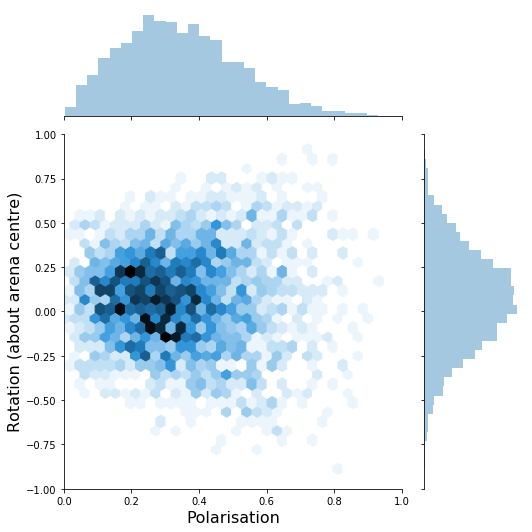

In [83]:
plot = sns.jointplot(df_ord['polarisation'], df_ord['arena_rotation']['sum'], xlim=[0,1], ylim=[-1,1], kind="hex", space=0, size = 7.5, stat_func=None, ratio=3)
plot.set_axis_labels('Polarisation', 'Rotation (about arena centre)', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex4_fig3b.eps', format='eps', dpi=300)
plt.show()

In [30]:
print(np.median(df_ord['polarisation']), np.median(np.abs(df_ord['rotation']['sum'])), np.median(np.abs(df_ord['arena_rotation']['sum'])))

0.32835415043948535 0.21825415958494676 0.18926017785324067
